# Regression Model Evaluation
### March 2016

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest, f_regression

### define functions

In [2]:
def helpFloat(x): 
    try:
        return float ( float(x['thumbsup']) / (float(x['thumbsup']) + float(x['thumbsdown'])) )
    except:
        return 0
    
def thumbsSum(x): 
    try:
        return int(x['thumbsup']) + int(x['thumbsdown']) 
    except:
        return 0
    
def simple_spearman(x,y): return np.abs(spearmanr(x,y)[0])
spearmanr_scorer = make_scorer(simple_spearman)

### load buscape reviews

In [4]:
reviews_features = pd.read_csv('reviews.csv.gz', compression='gzip')
#reviews_features = pd.read_csv('amazon-help.csv.gz', compression='gzip')
reviews_features['helpfulness'] = reviews_features.apply(helpFloat,axis=1)
reviews_features['thumbstotal'] = reviews_features.apply(thumbsSum,axis=1)
reviews_features.shape

(32226, 49)

### filter dataset

In [6]:
reviews_features = reviews_features[reviews_features.thumbstotal>4]
reviews_features = reviews_features[reviews_features.word_count>9]
#reviews_features = reviews_features.sample(frac=0.6)
reviews_features = reviews_features[np.isfinite(reviews_features.helpfulness)]
reviews_features.shape

(9451, 49)

### split data and class

In [7]:
# split class and features
labels = reviews_features["helpfulness"].values
reviews_columns = reviews_features.select_dtypes(include=['float64','int']).columns.drop('helpfulness')
features = reviews_features[list(reviews_columns)].values

# clean features
features = np.abs(features)
features[np.isnan(features) == True] = 0

features.shape

(9451, 38)

## 1. Run 10-fold cross validation over N kbest features

In [17]:
def cv4kBest(model, feats, labs, cvOpt, loops):
    result_list = []
    for i in range(14, loops+1):
        kbest_features = SelectKBest(f_regression, k=i).fit_transform(feats, labs)
        scores = cross_val_score(model, kbest_features, labels, cv=cvOpt, scoring=spearmanr_scorer)
        result_list.append(scores.mean())

        print str(i) + ',' + str(scores.mean())
        
    return result_list

###  1.1. for  linear regression

In [15]:
linear_model = LinearRegression()

spearmanr_scores_linear = cv4kBest(linear_model, features, labels, 10, 20)

1,0.250789417639
2,0.279124022854
3,0.276783639417
4,0.245064686773
5,0.243251890431
6,0.242389890957
7,0.237559707384
8,0.243548228148
9,0.241763380781
10,0.251131167361
11,0.250925651578
12,0.253330686411
13,0.251657397433
14,0.250884522496
15,0.251290812344
16,0.248982848437
17,0.248479884088
18,0.249127114916
19,0.24914964539
20,0.246884680263


###  1.1. for svm linear regression

In [14]:
linearSVR_model = LinearSVR(epsilon=0.01)

spearmanr_scores_svrLinear = cv4kBest(linearSVR_model, features, labels, 10, 20)

1,0.250789417639
2,0.263930531209
3,0.245449412572
4,0.131721003546
5,0.214905786537
6,0.200224304962
7,0.188947872805
8,0.175311686922
9,0.133132988403
10,0.174292176078
11,0.192901048777
12,0.17572936307
13,0.183113169604
14,0.18297918877
15,0.206140288999
16,0.206299791205
17,0.184215581353
18,0.16864970188
19,0.192540133131
20,0.184842647102


###  1.2. for rbf regression

In [16]:
svr_model = SVR(C=1.0, epsilon=0.01, kernel='rbf')

spearmanr_scores_svr = cv4kBest(svr_model, features, labels, 10, 20)

1,0.24793394135
2,0.18092968051
3,0.135473689789
4,0.106537195503
5,0.109620389192
6,0.113410813569
7,0.0806673415542
8,0.0814913285225
9,0.0573649770001
10,0.0466235215971
11,0.0490897451949
12,0.0664417009683
13,0.0622295658347
14,0.0662270568864
15,nan
16,nan
17,nan
18,nan
19,nan
20,nan


### 1.3 Plot Chart

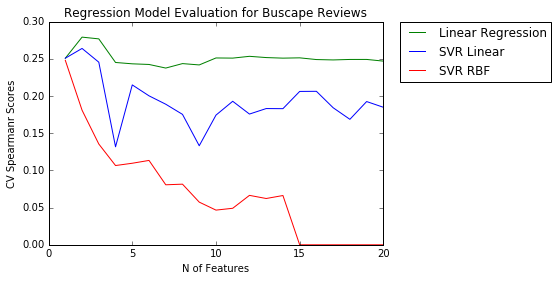

In [31]:
plt.figure()

n_features = range(1, 21)

plt.plot(n_features, spearmanr_scores_linear, 'g', label='Linear Regression')
plt.plot(n_features, spearmanr_scores_svrLinear, 'b', label='SVR Linear')
plt.plot(n_features, spearmanr_scores_svr, 'r', label='SVR RBF')
plt.xlabel('N of Features')
plt.ylabel('CV Spearmanr Scores')
plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Regression Model Evaluation for Buscape Reviews')
plt.show()

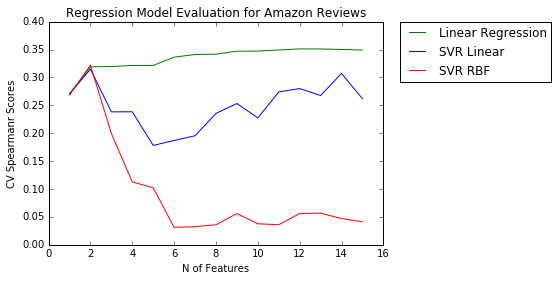

In [43]:
plt.figure()

n_features = range(1, 16)

plt.plot(n_features, spearmanr_scores_linear, 'g', label='Linear Regression')
plt.plot(n_features, spearmanr_scores_svrLinear, 'b', label='SVR Linear')
plt.plot(n_features, spearmanr_scores_svr, 'r', label='SVR RBF')
plt.xlabel('N of Features')
plt.ylabel('CV Spearmanr Scores')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Regression Model Evaluation for Amazon Reviews')
plt.show()